# Diabetes 
#### Model Comparison - Logistic Regression, Support Vector Classifier, Random Forest, Ridge Classifier
Data source: 
https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

## Imports

In [1]:
import numpy as np
import pandas as pd
import itertools
from scipy.io.arff import loadarff
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [24]:
# Constants
PATH = r"C:\Users\H\Dev\Datasets\HealthData\\"
DATA = 'pima_diabetes.arff'

# Matplot styles 
STYLES = ['default', 'seaborn-v0_8-colorblind','seaborn-v0_8-white',
          'fivethirtyeight', 'ggplot']

FEATURES = ['preg', 'plas','pres', 'skin', 'insu', 'mass', 'pedi', 'age']
LABELS =['Negative', 'Positive']
CLASSES = 2
RANDOM_STATE = 43

# Plots
COLOURS =['#00a8ff', '#8c7ae6']
OFFSETS = [0.03, 0.03]

In [25]:
def produce_confusion_matrix(y_test, prediction,
                             classes=CLASSES,
                             labels=LABELS,
                             normalise=False):
    cm = confusion_matrix(y_true=y_test, y_pred=prediction)
    rows = cm.shape[0]
    cols = cm.shape[1]

    cmap=plt.cm.Blues
    title='Confusion Matrix'
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=17)
    plt.colorbar()
    tick_marks = np.arange(classes)
    plt.xticks(tick_marks, labels, rotation=30, fontsize=14)
    plt.yticks(tick_marks, labels, fontsize=14)

    for i, j in itertools.product(range(rows), range(cols)):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment='center',
                color='white' if (cm[i,j] > cm.max() / 2.) else 'black')
    plt.tight_layout()
    plt.ylabel('Actual Label', fontsize=15)
    plt.xlabel('Predicted Label', fontsize=15)
    plt.show();
    return cm

def get_test_accuracy(model, x_test, y_test, prediction):
    nr_correct = (y_test == prediction).sum()
    nr_incorrect = (y_test.size - nr_correct).sum()
    print("<<< Test Data Inference >>>")
    print(f'Correct prediction counts: {nr_correct}\nIncorrect prediction counts: {nr_incorrect}')
    # Accuracy test
    accuracy = model.score(x_test, y_test)
    frac_wrong = nr_incorrect / len(y_test)
    print(f'Test Accuracy: {accuracy:.2%}\nThe rate of wrong prediction: {frac_wrong:.3%}')

# Precision
def get_precision(cm):
  true_pos = np.diag(cm)
  score = true_pos / np.sum(cm, axis=0) # true pos + true neg
  print("Precision")
  print(f'{LABELS}\n{score}')
  return score

# Recall
def get_recall(cm):
  true_pos = np.diag(cm)
  score = true_pos / np.sum(cm, axis=1) # true pos + false neg
  print("Recall")
  print(f'{LABELS}\n{score}')
  return score


# F1-score
def get_f_1_score(cm, y_true, y_hat):
    """
    this computes unweighted F1 scores: by class and averaged unweighted
    also prints out precision and recall scores for each class
    """
    recall = get_recall(cm)
    precision = get_precision(cm)

    avg_recall = np.mean(recall)
    avg_prec = np.mean(precision)

    f1 = 2 * ((avg_recall * avg_prec) / (avg_recall + avg_prec))
    print(f'Unweighted F1 Score: {f1}')
    print(f'F1 score for each class: {LABELS}\n{f1_score(y_true, y_hat, average=None)}')

    weighted_f1 = f1_score(y_true, y_hat, average='weighted')
    print(f'Weighted overall F1: {weighted_f1}')

# Data

### Load data and explore

In [4]:
# Read data and convert to pandas dataframe
raw = loadarff(PATH + DATA)
data = pd.DataFrame(raw[0])
data.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,b'tested_positive'
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,b'tested_negative'
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,b'tested_positive'
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,b'tested_negative'
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,b'tested_positive'


In [5]:
# Check for null/empty values
print(data.isna().any())
print(data.isnull().any())
data.info(show_counts = True)

preg     False
plas     False
pres     False
skin     False
insu     False
mass     False
pedi     False
age      False
class    False
dtype: bool
preg     False
plas     False
pres     False
skin     False
insu     False
mass     False
pedi     False
age      False
class    False
dtype: bool
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    float64
 1   plas    768 non-null    float64
 2   pres    768 non-null    float64
 3   skin    768 non-null    float64
 4   insu    768 non-null    float64
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    float64
 8   class   768 non-null    object 
dtypes: float64(8), object(1)
memory usage: 54.1+ KB


In [6]:
data.describe()

,preg,plas,pres,skin,insu,mass,pedi,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


### Preprocessing

In [7]:
# The label (test result) is in a string format, needs to be turned it into numerical value
data['class'] = data['class'].astype('string')
data['class'] = data['class'].str.replace('b\'', '')
data['class'] = data['class'].str.replace('\'', '')
data['class'] = data['class'].apply(lambda x: x.strip())

In [8]:
# Create a new label column based on the class attribute
conditions = [data['class'].str.contains('tested_positive'),
             data['class'].str.contains('tested_negative')]
values = [1, 0]
data['label'] = np.select(conditions, values)

In [9]:
data.head() # after creating a new column with the label

,preg,plas,pres,skin,insu,mass,pedi,age,class,label
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,tested_positive,1
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,tested_negative,0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,tested_positive,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,tested_negative,0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,tested_positive,1


In [10]:
# dataframe to be used for plots
df = data.drop('class', axis=1)
df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,label
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1


### Visaulise data

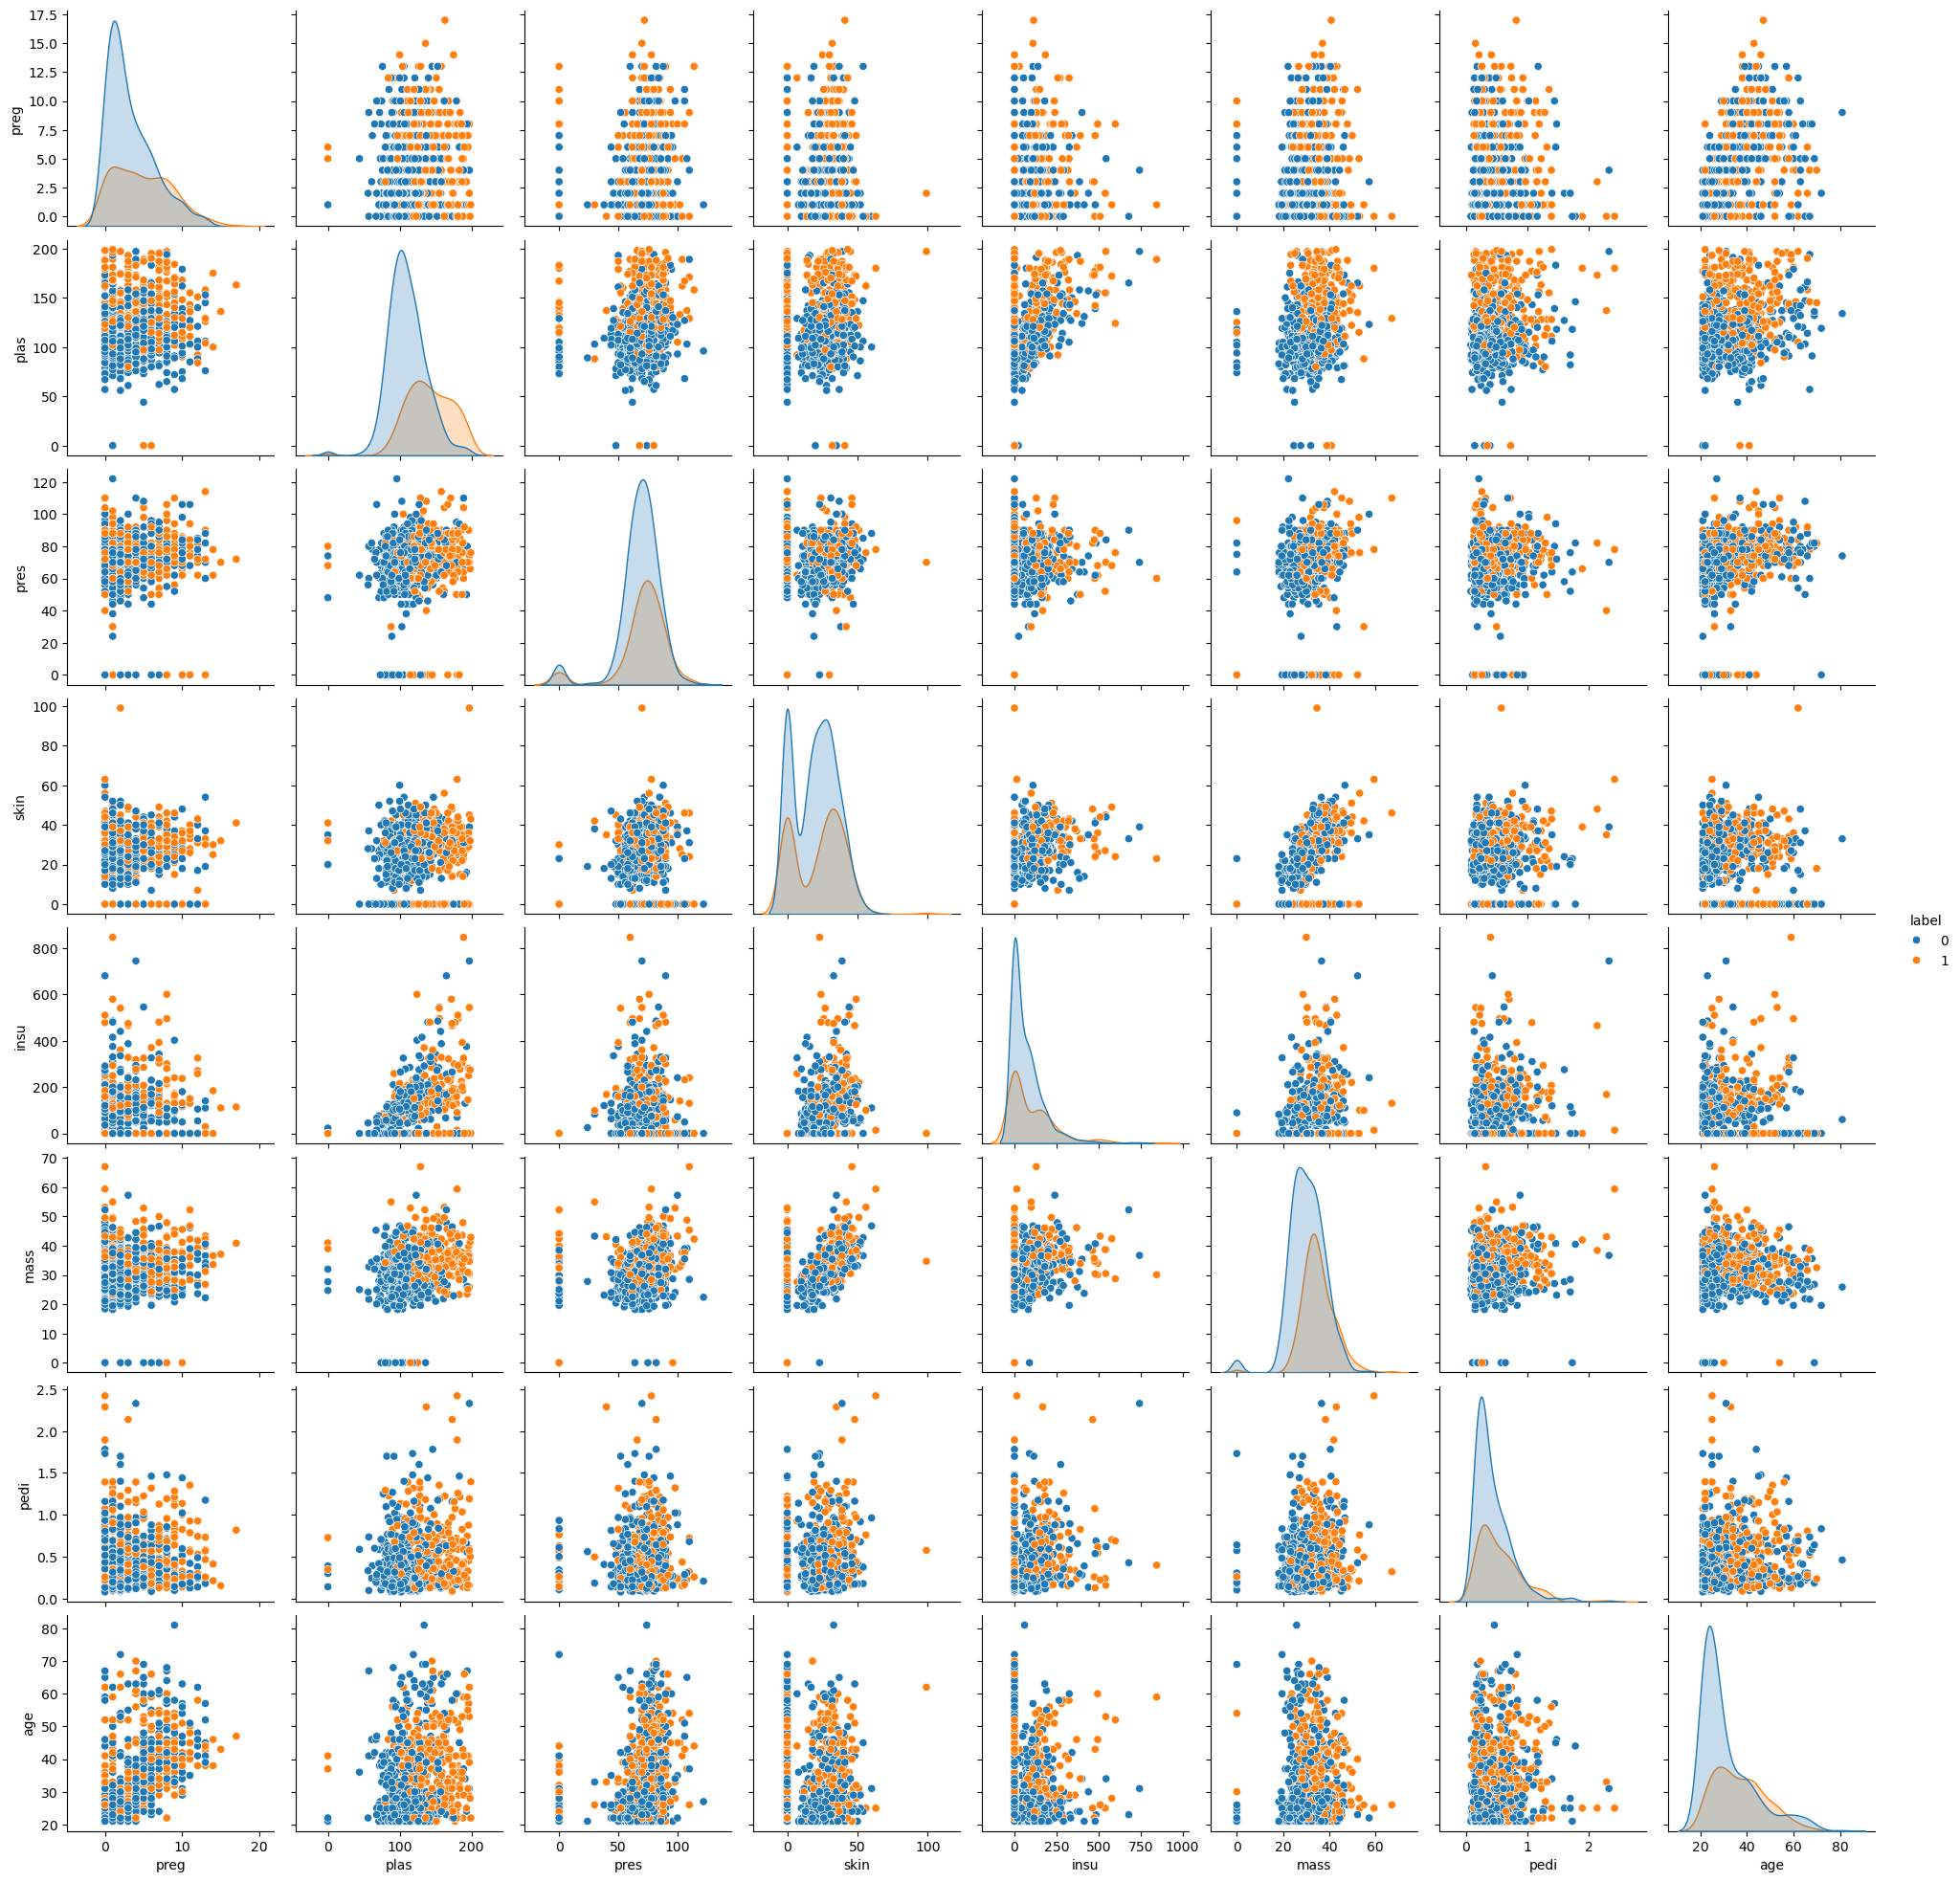

In [11]:
# Pair plots
sns.pairplot(df, hue='label')
plt.show();

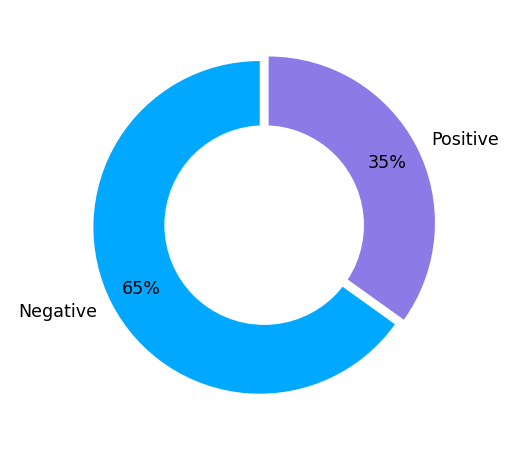

In [26]:
# Pie chart
neg_count = (df['label'] == 0).sum()
pos_count = (df['label'] == 1).sum()
size = [neg_count, pos_count ]

#Pie chart
plt.figure(figsize=(3, 3), dpi=180)
plt.pie(size,
        labels=LABELS,
        colors=COLOURS,
        textprops={'fontsize': 7},
        startangle=90,
        autopct='%1.0f%%',
        pctdistance=0.8,
        explode=OFFSETS)
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')  #coordinates, radius, centre colour
plt.gca().add_artist(centre_circle) # get current axis and add new circle to it

plt.show()

### Split data

In [13]:
X = df.iloc[:, :8] # features
Y = df['label'] # label
print(f'X {X.shape}, Y = {Y.shape}')

X (768, 8), Y = (768,)


In [14]:
# Data spllit
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)

In [15]:
# Normalise data
#scaler = PowerTransformer() # similar to Standard S
scaler = StandardScaler() # best
#scaler = MinMaxScaler()  # worst
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
print(f'x_train size: {x_train.shape}, y_train size: {len(y_train)}')
print(f'x_test size: {x_test.shape}, y_test size: {len(y_test)}')

x_train size: (614, 8), y_train size: 614
x_test size: (154, 8), y_test size: 154


# 1. Logistic regression


### Train and evaluation

In [16]:
model_logistic = LogisticRegression(random_state=42)
model_logistic.fit(x_train, y_train)
print('intercept', model_logistic.intercept_)
# generate a dataframe with coefficients of each features
print(pd.DataFrame(data=model_logistic.coef_[0], index=FEATURES, columns=['coef']))
train_accuracy = model_logistic.score(x_train, y_train)
print(f'Train accuracy = {train_accuracy:.3f}, {train_accuracy:.2%}')

intercept [-0.88599662]
          coef
preg  0.438867
plas  1.076213
pres -0.323789
skin -0.056765
insu -0.070500
mass  0.754225
pedi  0.487183
age   0.134314
Train accuracy = 0.787, 78.66%


### Evaluate with test data

<<< Test Data Inference >>>
Correct prediction counts: 120
Incorrect prediction counts: 34
Test Accuracy: 77.92%
The rate of wrong prediction: 22.078%
Confusion matrix without normalisation


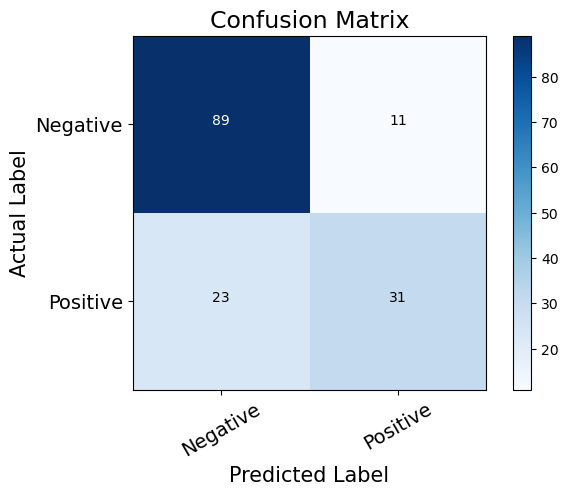

Recall
['Negative', 'Positive']
[0.89       0.57407407]
Precision
['Negative', 'Positive']
[0.79464286 0.73809524]
Unweighted F1 Score: 0.7488097287387979
F1 score for each class: ['Negative', 'Positive']
[0.83962264 0.64583333]
Weighted overall F1: 0.7716705464346973


In [17]:
# Make prediction using test data
pred_logistic = model_logistic.predict(x_test)
get_test_accuracy(model=model_logistic, x_test=x_test, y_test=y_test, prediction=pred_logistic)
# confusion Matrix and f1
cm = produce_confusion_matrix(y_test=y_test, prediction=pred_logistic)
get_f_1_score(cm=cm,y_true=y_test, y_hat=pred_logistic)

# 2. Support Vector Machine

### Train and evaluation

In [18]:
model_svc = LinearSVC(penalty='l2', C=1.0, max_iter=100)  #
model_svc.fit(x_train, y_train)

print('intercept', model_svc.intercept_)
# generate a dataframe with coefficients of each features
print(pd.DataFrame(data=model_svc.coef_[0], index=FEATURES, columns=['coef']))
train_accuracy = model_svc.score(x_train, y_train)
print(f'SVC Train accuracy = {train_accuracy:.3f}, {train_accuracy:.2%}')


intercept [-0.32985224]
          coef
preg  0.162196
plas  0.401025
pres -0.118894
skin -0.021398
insu -0.025957
mass  0.272026
pedi  0.173620
age   0.048891
SVC Train accuracy = 0.787, 78.66%


### Evaluate with test data

<<< Test Data Inference >>>
Correct prediction counts: 121
Incorrect prediction counts: 33
Test Accuracy: 78.57%
The rate of wrong prediction: 21.429%
Confusion matrix without normalisation


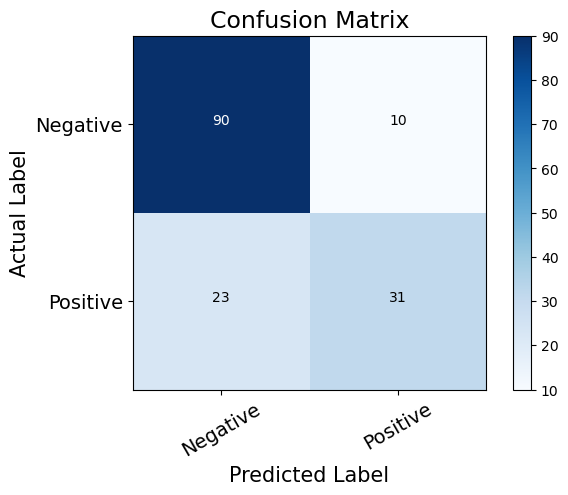

Recall
['Negative', 'Positive']
[0.9        0.57407407]
Precision
['Negative', 'Positive']
[0.79646018 0.75609756]
Unweighted F1 Score: 0.7561491625559555
F1 score for each class: ['Negative', 'Positive']
[0.84507042 0.65263158]
Weighted overall F1: 0.7775918669914221


In [19]:
pred_svc = model_svc.predict(x_test)
# Accuracy
get_test_accuracy(model=model_svc, x_test=x_test, y_test=y_test, prediction=pred_svc)
#
cm = produce_confusion_matrix(y_test=y_test, prediction=pred_svc)
get_f_1_score(cm=cm,y_true=y_test, y_hat=pred_svc)

# 3. Random Forest

### Train and evaluation

In [20]:
model_rf = RandomForestClassifier(n_estimators=4) #
model_rf.fit(x_train, y_train)

train_accuracy = model_rf.score(x_train, y_train)
print(f'Random Forest Train accuracy = {train_accuracy:.3f}, {train_accuracy:.2%}')

Random Forest Train accuracy = 0.935, 93.49%


### Evaluate with test data

<<< Test Data Inference >>>
Correct prediction counts: 113
Incorrect prediction counts: 41
Test Accuracy: 73.38%
The rate of wrong prediction: 26.623%
Confusion matrix without normalisation


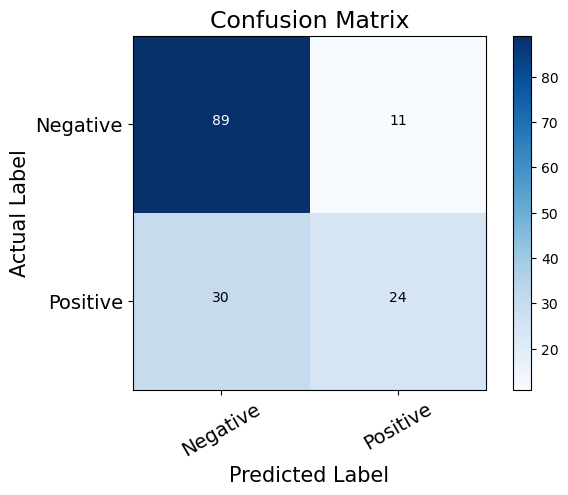

Recall
['Negative', 'Positive']
[0.89       0.44444444]
Precision
['Negative', 'Positive']
[0.74789916 0.68571429]
Unweighted F1 Score: 0.6911262602923168
F1 score for each class: ['Negative', 'Positive']
[0.81278539 0.53932584]
Weighted overall F1: 0.7168969760935284


In [21]:
pred_rf = model_rf.predict(x_test)
get_test_accuracy(model=model_rf, x_test=x_test, y_test=y_test, prediction=pred_rf)
#
cm = produce_confusion_matrix(y_test=y_test, prediction=pred_rf)
get_f_1_score(cm=cm, y_true=y_test, y_hat=pred_rf)

# 4.  Ridge Classifier

In [22]:
model_rc = RidgeClassifier(alpha=1.5, solver='svd', random_state=RANDOM_STATE)
model_rc.fit(x_train, y_train)

print('intercept', model_rc.intercept_)
# generate a dataframe with coefficients of each features
#print(pd.DataFrame(data=model_rc.coef_[0], index=FEATURES, columns=['coef']))

train_accuracy = model_rc.score(x_train, y_train)
pred_rc = model_rc.predict(x_test)
print(f'Ridge Classifier Train accuracy = {train_accuracy:.3f}, {train_accuracy:.2%}')


intercept [-0.3029316]
Ridge Classifier Train accuracy = 0.783, 78.34%


### Evaluate with test data

<<< Test Data Inference >>>
Correct prediction counts: 121
Incorrect prediction counts: 33
Test Accuracy: 78.57%
The rate of wrong prediction: 21.429%
Confusion matrix without normalisation


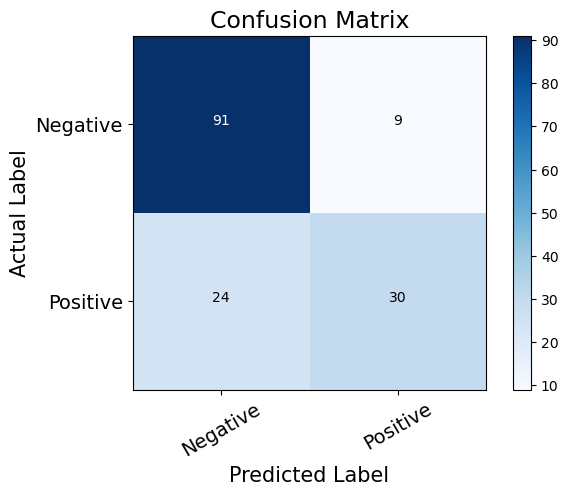

Recall
['Negative', 'Positive']
[0.91       0.55555556]
Precision
['Negative', 'Positive']
[0.79130435 0.76923077]
Unweighted F1 Score: 0.7557773899973106
F1 score for each class: ['Negative', 'Positive']
[0.84651163 0.64516129]
Weighted overall F1: 0.7759082627799807


In [23]:
pred_rc = model_rc.predict(x_test)
get_test_accuracy(model=model_rc, x_test=x_test, y_test=y_test, prediction=pred_rc)
#
cm = produce_confusion_matrix(y_test=y_test, prediction=pred_rc)
get_f_1_score(cm=cm, y_true=y_test, y_hat=pred_rc)

#### Among all models both Support vector and Ridge performs best with a test accuracy 78.6%